# Twitter Airline Sentiment Analysis using ULMFiT

In [82]:
# import necessary modules
%reload_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.text import *
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline 

## Preparing dataset

In [98]:
df = pd.read_csv("C:/Users/manas/Desktop/fellowship_ai/Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As the entries are in chunks one airline at a time, we will randomize it to reduce imbalance.

In [99]:
df = df.reindex(np.random.permutation(df.index))
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
114,569861209781989377,positive,0.3482,NaN,0.0000,Virgin America,NaN,AdamJdubs,NaN,0,@VirginAmerica come back to #PHL already. We n...,NaN,2015-02-23 06:07:54 -0800,Earth,Eastern Time (US & Canada)
742,570106249024446464,neutral,0.6760,NaN,0.0000,United,NaN,fairplay500,NaN,0,@united I send you an urgent message via eserv...,"[0.0, 0.0]",2015-02-23 22:21:36 -0800,Huntsville AL USA,Central Time (US & Canada)
9984,569592120954236928,negative,1.0000,Can't Tell,1.0000,US Airways,NaN,FiVeBoRoUghS718,NaN,0,@USAirways really nigga.. Ur a fuck boy,"[40.85214382, -73.28567395]",2015-02-22 12:18:38 -0800,NaN,NaN
9836,569647082870415361,negative,0.6735,Cancelled Flight,0.3469,US Airways,NaN,tworstwots,NaN,0,@USAirways pilot tells me that all @AmericanAi...,NaN,2015-02-22 15:57:02 -0800,"San Francisco, CA",Eastern Time (US & Canada)
3767,568141110217805824,negative,1.0000,Flight Booking Problems,0.6526,United,NaN,jenny0z,NaN,0,@united I usually like flying with you guys bu...,NaN,2015-02-18 12:12:50 -0800,new york city,NaN


In [77]:
print(df.shape)

(14640, 15)


There are 15 features, but we would focus on airline sentiment, and text. First we will look into their distributions.

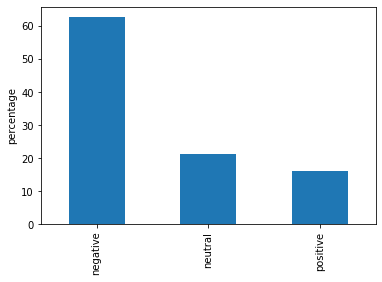

In [97]:
# distribution of sentiment
plt.rcParams['figure.figsize'] = 6,4
df.airline_sentiment.value_counts(normalize=True).mul(100).plot(kind = 'bar')
plt.ylabel('percentage')
plt.show()

More than 60% airline sentiments are recorded as negative, seems reasonable as people usually comment when they encounter some negative experience. However, it would be difficult to differentiate neutral comments. 

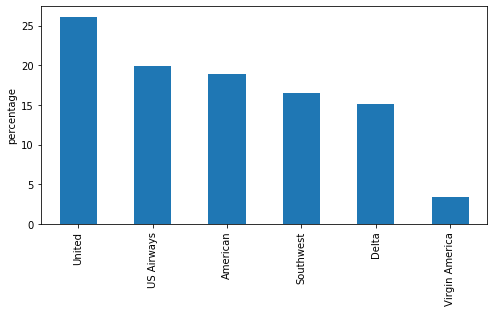

In [96]:
# distribution of airlines
plt.rcParams['figure.figsize'] = 8,4
df['airline'].value_counts(normalize=True).mul(100).plot(kind='bar')
plt.ylabel('percentage')
plt.show()

Most people commented had flight with United and least of them with Virgin America. Now we will explore how people from different airline felt.

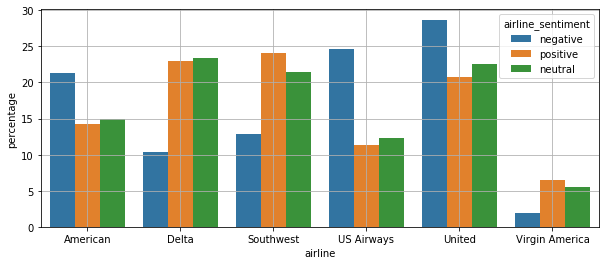

In [83]:
# distribution of sentiments among airlines:
var = df.groupby(['airline_sentiment'])['airline'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('airline')
plt.rcParams['figure.figsize'] = 10,4
sns.barplot(x='airline', y='percentage', hue='airline_sentiment', data=var)

plt.grid(True)
plt.show()

Evidently United received most negative comments, and American, US Airways and United collectively received >70% of total negative comments. On the contrary, Virgin America got only 2.5% of the total negative comments. Next, we will focus on the text.

In [4]:
# what they wrote!
df.text

2028     @united  once again your customer service at t...
12776    @AmericanAir TSA said there is nothing they co...
172      @VirginAmerica to begin Dallas-Austin #flights...
90       @VirginAmerica "You down with RNP?" "Yeah you ...
1006     @united Just checking in again - what is the s...
                               ...                        
1640     @united Pay for a cab back to the airport to s...
10196    @USAirways you need to figure your scheduling ...
10057    @USAirways might possibly be THE WORST airline...
13628    @AmericanAir @Cowboycerrone You apologise for ...
5487     @SouthwestAir -17mph winds and would do anythi...
Name: text, Length: 14640, dtype: object

## Sentiment Analysis using ULMFiT

Transfer learning in NLP is now typically done as a multi-step process: an entire network is first pre-trained in an unsupervised manner with a language modelling objective. Following this, the model is then fine-tuned on a new task using a supervised approach, which can then be used for tasks such as text classification. This combination of unsupervised pre-training (using language modelling) followed by supervised fine-tuning is termed as semi-supervised learning.

Here we will use language model to build a text classifier using fast.ai library. This is done in 3 steps:

1. Data preprocessing
2. Create a language model with pre-trained weights that can be fine-tuned for our specific dataset
3. Create a classifier on top of the language model

We will split the table for train test purpose. We will keep aside 10% for test/validation. For the language model we will use the entire table. We will write them in seperate csv files.

In [118]:
fraction = 0.1
df.sort_index(inplace=True)
split_df = int(fraction * df.shape[0])
df[['airline_sentiment', 'text']][:split_df].to_csv('Tweets_test.csv', index=False, encoding='utf-8') # for testing classifier
df[['airline_sentiment', 'text']][split_df:].to_csv('Tweets_train.csv', index=False, encoding='utf-8') # for training classifier
df[['text']][:].to_csv('Tweets_text_train.csv', index=False, encoding='utf-8') # for train test language model

## Data Preprocessing

The text module of the fastai library contains all the necessary functions to define a Dataset suitable for the various NLP (Natural Language Processing) tasks and quickly generate models we can use for them. Specifically: text.transform contains all the scripts to preprocess the data from raw text to token ids, text.data contains the definition of TextDataBunch, which the main class needed in NLP, and text.learner contains functions to quickly create a language model or an RNN (Recurrent Neural Network) classifier.

TextDataset automatically does the preprocessing step. It also contains all the functions to quickly get a TextDataBunch ready. We will use from_csv API for text preprocessing. Below we can see how the data is encoded by fast.ai.

## Tekenization

In [22]:
data = TextClasDataBunch.from_csv('.', 'Tweets_train.csv')
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
"xxbos @southwestair i had to travel to xxmaj savannah , xxup ga , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
xxbos @united - xxmaj kids left a kindle fire xxup hd 6 onboard xxup xxunk ( xxup ord - xxup sfo ) today . xxmaj row xxup xxunk - xxup def ( we had the whole row amongst the 5 of us ) . xxmaj help ...,neutral


The following changes have been made to the text for ease of modeling:

1. Split on space and punctuation symbols.
2. The "'s" are grouped together in one token.
3. The contractions are separated like this: "did", "n't".
4. There are several special tokens (all those that begin by xx). These are tags to retain information which can be used to gather an understanding of the new task’s vocabulary. All punctuation, hashtags and special characters are also retained. For example, xxbos suggests beginning of a sentence, xxfld means separate parts of a document like title, summary etc., xxup suggests all in caps, xxunk means unknown word, xxunc suggests uncommon words, xxrep means repeated words and so on. 


List of unique tokens is called vocabulary. The first 10 unique tokens in order of frequency are shown below.

In [23]:
data.vocab.itos[:10]


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [102]:
data.train_ds

LabelList (10540 items)
x: TextList
xxbos @jetblue thx , social media person !,xxbos @united xxmaj then why did your staff refuse to let xxup me on the earlier flight xxunk my having checked a bag ? ! ? !,xxbos @usairways xxmaj already tried . xxmaj how about xxmaj conf # via xxup dm,xxbos @jetblue where is it coming from ? i thought xxmaj tampa ?,xxbos “ @southwestair : xxunk xxmaj can you follow back for a quick xxup dm ? xxunk
y: CategoryList
positive,negative,negative,negative,neutral
Path: .

In [24]:
print(data.train_ds[0][0])
print(data.train_ds[1][0])
print(data.train_ds[2][0])

xxbos @jetblue thx , social media person !
xxbos @united xxmaj then why did your staff refuse to let xxup me on the earlier flight xxunk my having checked a bag ? ! ? !
xxbos @usairways xxmaj already tried . xxmaj how about xxmaj conf # via xxup dm


In [25]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[1][0].data[:10])
print(data.train_ds[2][0].data[:10])

[  2  31 366  18 850 735 330  13]
[   2   27    5  141   94  100   38  246 1327   10]
[  2  24   5 239 293   9   5  88 112   5]


This is how the tokens are replaced with numbers as per their positions (/index) as the model can deal easily with it. The default vocabulary size is set to 60,000 words and minimum count for a word to be added to this vocabulary is 2, to avoid getting the weight matrix huge.

## Language model

A language model attempts to learn the structure of natural language through hierarchical representations, and thus contains both low-level features (word representations) and high-level features (semantic meaning). A key feature of language modelling is that it is generative, meaning that it aims to predict the next word given a previous sequence of words. It is able to do this because language models are typically trained on very large datasets in an unsupervised manner, and hence the model can “learn” the syntactic features of language in a much deeper way than word embeddings.

Fast.ai has a pre-trained wikitext model consisting 103 million tokens extracted from Wikipedia.The dataset retains the original case (it was not lower-cased before training the language model), and all punctuation and numbers are included. The type of text data included in this dataset includes sentences from full Wikipedia articles, so the hope is that the language model is able to capture and retain some longer-term dependencies from relatively complex sentences. This model understands the language adequately in terms of meaning and syntax and common usage. 

Next step is to fine-tune this model and do transfer learning to create a new language model that’s specifically good at predicting the next word in airline sentiments.

In [29]:
# language model 
bs = 24 #batchsize, depends on the computer gpu
seed = 333 # reproducibility 
data_lm = (TextList.from_csv('.', 'Tweets_text_train.csv')
            .random_split_by_pct(0.1, seed = seed)
           #randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [30]:
data_lm.show_batch()


idx,text
0,xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you xxbos @united it was delivered ! xxmaj thank you for making sure it arrived at my xxunk ! xxbos @united - rebooked
1,"good to know . xxbos @united okay . xxmaj thanks . xxbos @united xxmaj conference xxunk in 3 hours . xxmaj up all night due to delays and still waiting to talk to someone about lost luggage . xxbos @united xxmaj seat xxup xxunk , xxmaj flight xxup xxunk xxbos @united is it on a flight now ? xxmaj thanks for reply . xxbos @united is xxunk and i am"
2,"and the delay turns into a xxmaj cancelled xxmaj flight ... xxbos @united xxup ua xxunk delayed again - i get charged $ 600 if xxmaj late xxmaj flight by you - you say "" oh well "" xxbos @united we are trying to go as far away from king'scollegelondon as possible for # charity today . xxmaj would you help us ? # jailbreak # xxup rag xxbos @united"
3,"1st class . xxmaj xxunk ? xxmaj really ? @united : xxunk xxmaj your xxunk is xxunk xxbos @united xxmaj thanks xxmaj yup i 'm all set . xxmaj it happens . xxup slc ground staff were prompt , helpful and courteous . xxbos xxmaj there were plenty of empty seats in coach "" @united : xxmaj your xxunk is understood . xxmaj crew members traveling for duty are pre"
4,"when i boarded . xxbos “ @united : xxunk xxmaj sorry to hear about your flight . xxmaj do you need help reflight xxmaj booking xxmaj problems ? ” \n \n 👎 xxbos @united now we are trying to get to xxmaj san xxmaj juan from xxmaj chicago o'hare . xxmaj having lots of problems . xxmaj may get a standby flight . xxbos @united xxmaj alright , thank"


## Fine tuning of language model
Here we use the pretrained language model weights and fine tune with the airline sentiment dataset. The pretrained model is Wikitext 103. The language model data comes from data_lm.  

In [32]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


Argument drop_mult is a hyperparameter for regularization purpose. We should increase/decrease it in case the model is overfitting /underfitting. Next we will seach the optimum learning rate (with minimum loss) for this dataset using learn.lr_find(). The rule of thumb is to set the learning rate 1 magnitude less than what is found as optimum.

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


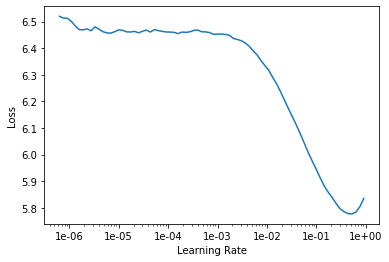

In [36]:
learn.recorder.plot(skip_end=12)


The optimum value is around 1e-1, we will choose 1e-2 as learning rate.

## Training the model
Here we train the model using fit_one_cycle with learning rate 1e-2, for epoch 1. By fitting one cycle, it would complete one cycle of learning rate, starting low, go up and then coming down. The argument moms stand for momentums. When the learning rate is small, the momentum is higher, but as the learning rate goes up the momentum goes down to avert overshooting the target. 
It trained the last layer and left the rest of the model as it was. 

In [37]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.102797,3.805460,0.265595,07:26


In [ ]:
The accuracy of the language model is 26.5% after running 1 epoch.

In [38]:
learn.save('fit_head')
# learn.load('fit_head')

After training the last layer we would unfreeze the whole model for training and train the whole model. This time we would choose 10 epochs.

In [40]:
learn.unfreeze()


In [41]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.720216,3.667307,0.287619,18:59
1,3.592381,3.588136,0.293423,18:29
2,3.411640,3.524141,0.303274,18:17
3,3.130198,3.515723,0.305089,18:52
4,2.770526,3.594357,0.302143,18:19
5,2.392918,3.707909,0.298393,18:34
6,2.078518,3.827466,0.294851,18:54
7,1.832284,3.929163,0.291577,19:36
8,1.667875,3.986760,0.292411,19:29
9,1.604423,4.006378,0.291190,19:46


Looks like the model is over-fitting slightly as the train_loss became smaller than valid_loss after 3rd round. We will see how the language model is working.

In [42]:
learn.save('fine_tuned')


In [43]:
learn.save_encoder('fine_tuned_enc')


After fine tuning we get this model good at understanding airline sentiment. We will save the encoding (part of the model that has the understanding of the sentence) of this model to use later for classification.

## Creating classifier

Now we will create a classifier to categorize the airline sentiments as 'positive', 'negative', and 'neutral'. First it would be trained using labelled train dataset and then be evaluated using test dataset.

In [46]:
data_clas = (TextList.from_csv('.', 'Tweets_train.csv', cols = 'text')               
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to xxunk it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @usairways xxmaj my xxmaj flight xxmaj booking xxmaj problems xxup xxunk just times out when i select it under xxmaj manage xxmaj my xxmaj flight xxmaj booking xxmaj problems for months now . i have emailed but no response . xxmaj help ?,negative
"xxbos @united ( 2 / 2 ) xxmaj it xxunk that if ca n't confirm xxunk at time of xxmaj flight xxmaj booking xxmaj problems , i should assume that it may never clear . xxmaj did n't used to be that way",negative
xxbos @united xxmaj missed xxup xxunk flight due to ur xxmaj cancelled xxmaj flightlation . xxmaj xxunk supervisor disgusting . xxmaj now day xxmaj late xxmaj flight . xxmaj no apology or upgrade offer to xxup lhr from xxup ord ? ? ?,negative


We will now create a text classifier learner, load in our pre train model, the encoding part we saved earlier ‘fine_tuned_enc’.

In [47]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11859 items)
x: TextList
xxbos @united the delay is due to customer service for 20 people ? xxmaj what about the xxup xxunk - xxup service you provided for 100 + ? # xxunk # xxunk,xxbos @united he is so excellent and so reliable :) # happycustomer,xxbos @united but again xxup united xxup xxunk xxup give 2 xxup xxunk xxup about xxup their xxup customers,xxbos @united xxmaj she is travelling from xxmaj xxunk ( xxmaj australia ) to xxmaj bogota ( xxmaj xxunk ) tomorrow,xxbos @united xxmaj hi . xxmaj my relative 's xxmaj flight xxmaj booking xxmaj problems number is xxup xxunk . xxmaj her name is xxmaj xxunk xxmaj xxunk xxmaj xxunk . xxmaj thank you
y: CategoryList
negative,positive,negative,neutral,neutral
Path: .;

Valid: LabelList (1317 items)
x: TextList
xxbos @usairways stuck on xxmaj tarmac for 30 mins at xxup phl waiting for someone to load baggage , ridiculous http : / / t.co / xxunk,xxbos @southwestair i consider myself a loyal

Again we will find the optimum learning rate for our model.

In [48]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


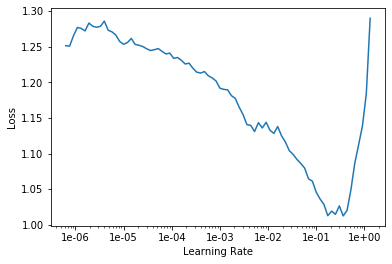

In [49]:
learn.recorder.plot()


The optimum learning rate seems to be around 1e-01, we will pick 2e-2. 

In [50]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.660515,0.526673,0.794229,05:43


We achieved almost 80% accuracy by training the last layer thanks to transfer learning. We will save it as 'first'.

In [51]:
learn.save('first')


It was empirically found that first fine-tuning only the last layer (with the others frozen), and then unfreezing all the layers and applying a learning rate lowered by a factor of 2.6 for all other layers during language model fine-tuning worked well in most cases.The gradual unfreezing avoids the phenomenon known as catastrophic forgetting (by losing all prior knowledge gained from the language model).
So, to improve the accuracy further, we will unfreeze one layer at a time, here the 2nd last layer. As we go from layer to layer, we decrease the learning rate. The lowest levels are given smaller learning rates so as not to disturb the weights much. This is called discriminative fine tuning. 

In [52]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.668024,0.500437,0.800304,07:37


In [53]:
learn.save('second')
# learn.load('second')

In [54]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.549520,0.457240,0.814730,15:06


In [55]:
# unfreezing the whole model for training
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.468849,0.447466,0.819286,21:09
1,0.423976,0.462957,0.817768,20:46
2,0.358935,0.448287,0.826120,21:34


The accuracy achieved is 82.6%. Next we will evaluate the performance using confusion matrix.

## Evaluate performance

In [57]:
test_df = pd.read_csv("Tweets_test.csv", encoding="utf-8")

In [ ]:
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))

In [63]:
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8066939890710383


The train and test accuracy is pretty consistent. 

In [64]:
test_df[:20]

,airline_sentiment,text,pred_sentiment
0,neutral,@VirginAmerica What @dhepburn said.,neutral
1,positive,@VirginAmerica plus you've added commercials t...,negative
2,neutral,@VirginAmerica I didn't today... Must mean I n...,negative
3,negative,@VirginAmerica it's really aggressive to blast...,negative
4,negative,@VirginAmerica and it's a really big bad thing...,negative
5,negative,@VirginAmerica seriously would pay $30 a fligh...,negative
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",negative
7,neutral,@VirginAmerica Really missed a prime opportuni...,negative
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D",neutral
9,positive,"@VirginAmerica it was amazing, and arrived an ...",positive


## Evaluation metrics

In [65]:
# confusion matrix
cm = confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'])

In [66]:
cm

array([[805,  40,  14],
       [101, 207,  31],
       [ 54,  43, 169]], dtype=int64)

The diagonal numbers represents correct classifications. While these numbers are high, there are number of misclassifications as well. We will plot the confusion matrix for easy understanding.

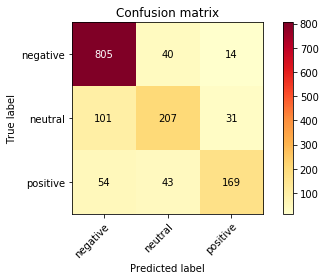

In [117]:
# # Confusion matrix plotting 
 
classes=['negative', 'neutral', 'positive']
cm = confusion_matrix(test_df['airline_sentiment'], test_df['pred_sentiment'])

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrRd)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes, yticklabels=classes,
        title = 'Confusion matrix',
        ylabel='True label',
        xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
#text annotation using loop
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

A high number of neutral comments are mis-classified as negative. But the overall accuracy is good. It is important to classify the negative comments correctly here. From that perspective, the model did a good job.

In [106]:
# example of mis-classified instances
test_df.loc[(test_df['airline_sentiment'] == 'neutral') & (test_df['pred_sentiment'] == 'negative')][:10]

,airline_sentiment,text,pred_sentiment
2,neutral,@VirginAmerica I didn't today... Must mean I n...,negative
7,neutral,@VirginAmerica Really missed a prime opportuni...,negative
27,neutral,@VirginAmerica do you miss me? Don't worry we'...,negative
43,neutral,@VirginAmerica I have an unused ticket but mov...,negative
50,neutral,@VirginAmerica Is flight 769 on it's way? Was ...,negative
60,neutral,@VirginAmerica @ladygaga @carrieunderwood Juli...,negative
65,neutral,@VirginAmerica Flight 0736 DAL to DCA 2/24 2:1...,negative
71,neutral,@VirginAmerica I emailed your customer service...,negative
86,neutral,@VirginAmerica Can't bring up my reservation o...,negative
94,neutral,@VirginAmerica why is flight 345 redirected?,negative


The mis-classification can be attributed to several things. twitter languages are often grammatically incorrect, with unstructured and messy language syntax. Its informal use, mis-spellings, inclusion of numerics (For example: 'I want 2 go'), special characters, and emojis within comments can reduce the accuracy of the language model. Further pre-processing and feature engineering to improve the language model specific to twitter comments can improve the accuracy.